In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d omkargurav/face-mask-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
100% 163M/163M [00:04<00:00, 40.7MB/s]
100% 163M/163M [00:04<00:00, 36.0MB/s]


In [3]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [4]:
# Load dataset and preprocess images
def load_and_preprocess_data(data_dir):
    categories = ['with_mask', 'without_mask']
    data = []
    labels = []

    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                img_resized = cv2.resize(img_array, (128, 128))
                data.append(img_resized)
                labels.append(class_num)
            except Exception as e:
                pass

    data = np.array(data) / 255.0
    labels = to_categorical(labels, num_classes=2)

    return data, labels

In [5]:
data_dir = './data'  # path to the extracted dataset
X, y = load_and_preprocess_data(data_dir)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

In [6]:
res101 = tf.keras.applications.ResNet101(include_top=False,
                                             weights='imagenet',
                                            input_shape=(128, 128, 3))

171446536/171446536 [==============================] - 5s 0us/step


In [7]:
for layer in res101.layers:
        layer.trainable = False


In [8]:
model = models.Sequential()
model.add(res101)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=64), epochs = 10, validation_data=(X_test, y_test),validation_split=0.2)
model.save('face_mask_model.h5')

Epoch 1/10
95/95 [==============================] - 48s 393ms/step - loss: 0.6746 - accuracy: 0.5927 - val_loss: 0.6785 - val_accuracy: 0.5520
Epoch 2/10
95/95 [==============================] - 36s 374ms/step - loss: 0.6423 - accuracy: 0.6356 - val_loss: 0.5850 - val_accuracy: 0.7101
Epoch 3/10
95/95 [==============================] - 33s 344ms/step - loss: 0.6068 - accuracy: 0.6647 - val_loss: 0.6083 - val_accuracy: 0.6585
Epoch 4/10
95/95 [==============================] - 34s 356ms/step - loss: 0.5942 - accuracy: 0.6779 - val_loss: 0.5647 - val_accuracy: 0.7022
Epoch 5/10
95/95 [==============================] - 34s 358ms/step - loss: 0.5958 - accuracy: 0.6748 - val_loss: 0.5650 - val_accuracy: 0.7062
Epoch 6/10
95/95 [==============================] - 32s 341ms/step - loss: 0.5890 - accuracy: 0.6816 - val_loss: 0.6536 - val_accuracy: 0.5976
Epoch 7/10
95/95 [==============================] - 32s 335ms/step - loss: 0.5813 - accuracy: 0.6842 - val_loss: 0.5152 - val_accuracy: 0.7492

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 43183234 (164.73 MB)
Trainable params: 525058 (2.00 MB)
Non-trainable params: 42658176 (162.73 MB)
_________

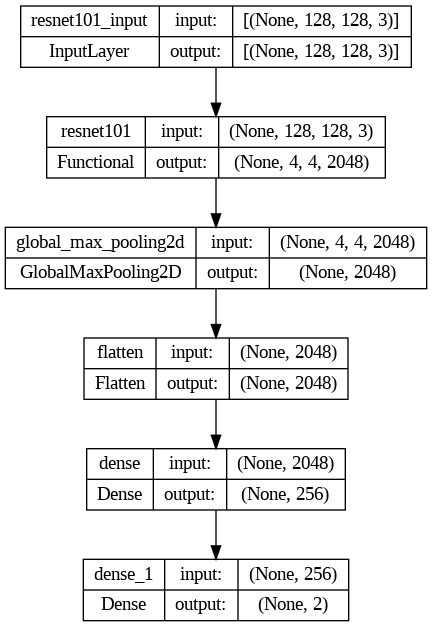

In [11]:
model.summary()

    # Visualize the model
visualization_path = 'model_visualization.png'
tf.keras.utils.plot_model(model, to_file=visualization_path, show_shapes=True, show_layer_names=True)

48/48 [==============================] - 3s 58ms/step - loss: 0.5404 - accuracy: 0.7081
Loss: 0.5403974652290344, Accuracy: 0.7081403136253357


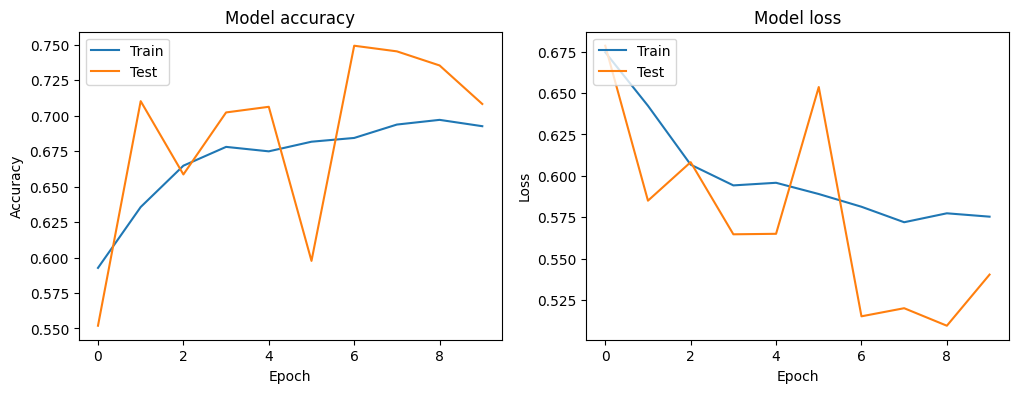

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


48/48 [==============================] - 3s 58ms/step


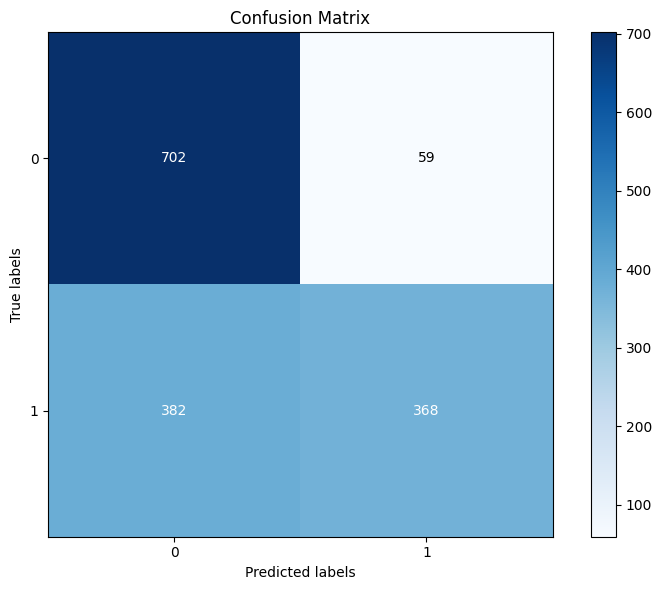


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       761
           1       0.86      0.49      0.63       750

    accuracy                           0.71      1511
   macro avg       0.75      0.71      0.69      1511
weighted avg       0.75      0.71      0.69      1511


Accuracy: 0.7081403044341495


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Predict classes for test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix as Matplotlib Image
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Adding Labels
num_classes = len(np.unique(y_true))
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

# Adding Text Annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.tight_layout()

# Save as Image or Show
# plt.savefig('confusion_matrix.png')  # Save as Image
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("\nAccuracy:", accuracy)


1/1 [==============================] - 0s 52ms/step


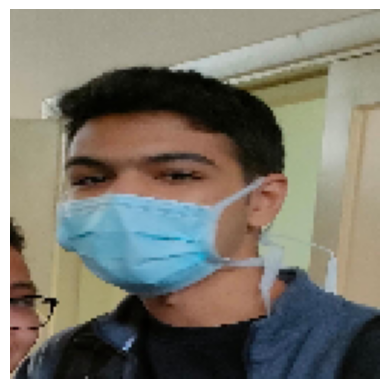

The image /content/guymask.jpeg is predicted to be: with mask with 66.59% confidence


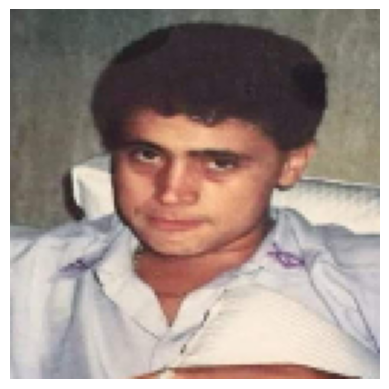

The image /content/john.jpeg is predicted to be: without mask with 73.40% confidence


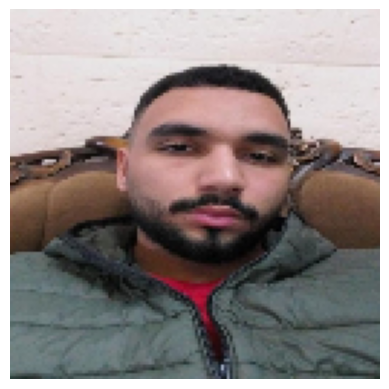

The image /content/disha.jpeg is predicted to be: without mask with 75.48% confidence


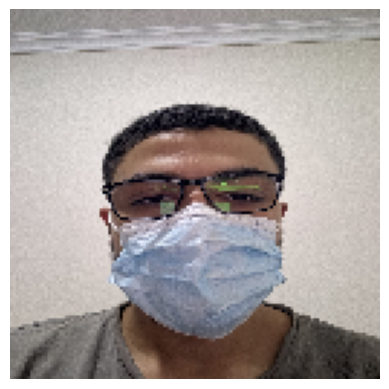

The image /content/amrmask.jpg is predicted to be: without mask with 67.06% confidence


In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_images(img_paths, model):
    class_labels = {0: "without mask", 1: "with mask"}
    predictions = []
    for img_path in img_paths:
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize to [0, 1]

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_label = class_labels[predicted_class]
        confidence = np.max(prediction) * 100

        predictions.append((img_path, predicted_label, confidence))

    return predictions


# Example of how to use the function to predict multiple images
img_paths = ['/content/guymask.jpeg', '/content/john.jpeg', '/content/disha.jpeg', '/content/amrmask.jpg']
predictions = predict_images(img_paths, model)

# Display the images and their predictions
for img_path, predicted_label, confidence in predictions:
    img_display = image.load_img(img_path, target_size=(128, 128))

    plt.imshow(img_display)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    print(f'The image {img_path} is predicted to be: {predicted_label} with {confidence:.2f}% confidence')

    model.save('face_mask_model.h5')
